# Raman Spectra Quality Control

## Setup

Import required packages

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from raman_lib.spectra_scoring import score_sort_spectra, score_names
from raman_lib.misc import load_data
from raman_lib.visualization import plot_spectra_peaks
from raman_lib.preprocessing import RangeLimiter, BaselineCorrector

Settings

In [2]:
# Name of the Dataset (for the output file)
name = "sersitive"

# Path where the data is stored
path = r"./data/sersitive daten/"

# Spectral range to analyze
# Use 'None' to use the whole range'
wn_min = None
wn_max = None

# QC settings - Choose either A or B and set the other to 'None'
# A)
n = 100 # How many spectra (per class) to keep (exactly this number - or less 
         # if a class does not contain enough spectra)
         
# B)
score_min = None # Minimum quality score that a spectrum must have to be kept.
n_min = None # Number of spectra that will be kept per class regardless of the score

# Window size for the Savitzky-Golay-Filter. Higher means stronger smoothing and less peaks found
sg_window = 50

# Threshold for the derivative. Higher means less peaks found.
threshold = 0.001

# Minimum height a peak must have to be detected
min_height = 50

# Plot baseline corrected (False) or raw spectra (True)
plot_raw = True

## Load Data

In [3]:
data = load_data(path)

print("Number of spectra per class:")
print(data.label.value_counts())

Number of spectra per class:
induziert 2        84
nicht induziert    63
Name: label, dtype: int64


## Scoring and Spectra Selection

In [4]:
data_new, deriv, score_dict = score_sort_spectra(data, 
                                                 n=n,
                                                 min_score=score_min, 
                                                 min_n=n_min,
                                                 limits=(wn_min, wn_max), 
                                                 sg_window=sg_window, 
                                                 threshold=threshold, 
                                                 min_height=min_height,
                                                 detailed=True)

print()
print("====================================")
print()
print("Number of spectra per class (after QC):")
print(data_new.label.value_counts())

Analyzed 147 spectra in 0.85 seconds.
Mean Score: 1994

1st Quartile: 258
Median Score: 1083
3rd Quartile: 2315

Min Score: 0
Max Score: 44814


Number of spectra per class (after QC):
induziert 2        84
nicht induziert    63
Name: label, dtype: int64


In [5]:
wns = data.drop(columns=["label", "file"]).columns
if plot_raw:
    data_plot = data.drop(columns=["label", "file"])
else:
    bl = BaselineCorrector()
    data_plot = bl.fit_transform(data.drop(columns=["label", "file"]))
    data_plot = pd.DataFrame(data_plot, columns=wns)

rl = RangeLimiter(lim=(wn_min, wn_max), 
                  reference=data_plot.columns)
data_plot = rl.fit_transform(data_plot)
wns_plot = data_plot.columns

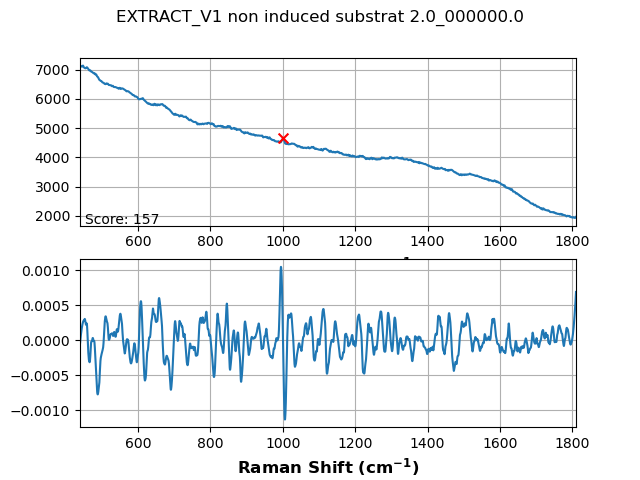

In [7]:
%matplotlib widget
plot_spectra_peaks(wns_plot, 
                   data_plot, 
                   deriv,
                   score_dict["peak_pos"],
                   score_dict["total_scores"],
                   labels=data.file)

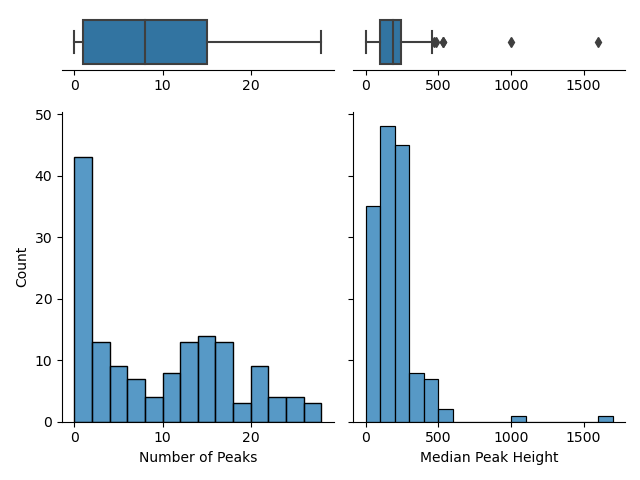

In [15]:
peak_xmax = None
int_xmax = None
ymax = None

fig, ((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = plt.subplots(
    2, 2, sharex="col", sharey="row", gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=score_dict["peak_scores"], ax=ax_box1)
sns.boxplot(x=score_dict["intensity_scores"], ax=ax_box2)
sns.histplot(score_dict["peak_scores"], ax=ax_hist1, binrange=None, binwidth=2)
sns.histplot(score_dict["intensity_scores"], ax=ax_hist2, binrange=None, binwidth=100)

ax_box1.set(yticks=[])
ax_box2.set(yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box1, left=True)
sns.despine(ax=ax_box2, left=True)

ax_hist1.set_xlim([None, peak_xmax])
ax_hist2.set_xlim([None, int_xmax])

ax_hist1.set_ylim([None, ymax])

ax_hist1.set_xlabel("Number of Peaks")
ax_hist2.set_xlabel("Median Peak Height")

ax_box1.tick_params(axis="x", labelbottom=True)
ax_box2.tick_params(axis="x", labelbottom=True)

fig.tight_layout()

## Export selected spectra

In [8]:
filename = name.lower().replace(" ", "_") + ".csv"

if not os.path.exists("./results_qc/"):
    os.mkdir("./results_qc/")

data_new.to_csv(os.path.join("./results_qc/", filename), index=False)

In [10]:
score_dict.keys()

dict_keys(['intensity_scores', 'peak_scores', 'total_scores', 'peak_pos'])

In [7]:
import numpy as np

x = np.array([[1, 2, 3, 4, 5],
              [1, 2, 3, 4, 5]])

In [8]:
np.shape(x)

(2, 5)